# Machine Learning: Basic Principles 2018
# Clustering

### Learning goals 

In this exercise you will learn how to organize a large number of data points into coherent groups (clusters) using clustering methods. In particular, we consider the hard clustering method __k-means__ and a soft clustering method which is motivated by probabilistic __Gaussian mixture models__.
### Exercise Contents

1. Introduction
2. Data
3. Exercise
    - The exercise consists of 3 tasks. Carefully read the task descriptions and instructions
    - 3.1 Hard clustering with k-means
    - 3.2 Handling local minima with k-means
    - 3.3 Soft clustering with Gaussian mixture models (GMMs)

 
    
  
### Keywords
`hard clustering`, `soft clustering`, `k-means`, `Gaussian mixture model (GMM)`, `unsupervised learning`.

##  1. Introduction
<a id="intro"></a>

On a high level, clustering is the task of dividing a (unlabeled) dataset $\mathbf{X} = \{ \mathbf{x}^{(i)} \}_{i=1}^{N}$, with $N$ data points $\mathbf{x}^{(i)} \in \mathbb{R}^{d}$, into a small number of groups or "clusters" $\mathcal{C}_{1},\ldots,\mathcal{C}_{k}$. Each cluster represents a subset of data points such that data points belonging to the same cluster are more similar to each other than to data points from another cluster. In contrast to regression and classification problems considered in earlier exercises, clustering methods do not require labeled data and can be applied to datasets whose data points $\mathbf{z}^{(i)}$ are characterized solely by its features $\mathbf{x}^{(i)}$. Therefore clustering methods are referred to as **unsupervised** machine learning methods.

There are two main flavors of clustering methods: 

* hard clustering methods  
* soft clustering methods


Hard clustering methods assign each data point to one and only one cluster. In contrast, soft-clustering methods assign each data point to several different clusters with varying probabilities.

We will apply one popular method for hard clustering (k-means) and one popular method for soft clustering (which is based on a probabilistic Gaussian mixture model) to a real-life application. In particular, consider you are running a Cafe in Helsinki and you want to segment customers in order to design a new marketing strategy for the upcoming summer. Such a customer segmentation can be done efficiently using clustering methods.

### 2. Data
<a id="steps_k-means"></a>

The Cafe owner wants to know if the customers can be grouped into subgroups of similar costumers. Based on this it might be useful to employ different marketing strategies targeting each group individually. So far the only information the owner collected was the age of the customers (there was a nasty incident in the past and now everyone is asked to show the ID when ordering alcoholic beverages) and the amount of money they spent (which can be recorded conveniently for card payments). The recordings are stored in the file "data.csv".

In the file "data.csv" you will find 400 rows, each of which contains the features for one data point (customer). The first column contains the age of the customers and the second column contains the amount of money they spent at the bar. Let us read it into a $400 \times 2$ numpy array and then visualize it using a scatter plot.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


,Age,Spending
0,28.018868,5.263333
1,27.897623,5.276452
2,29.042011,4.794357
3,29.669165,5.207227
4,29.494291,6.351539


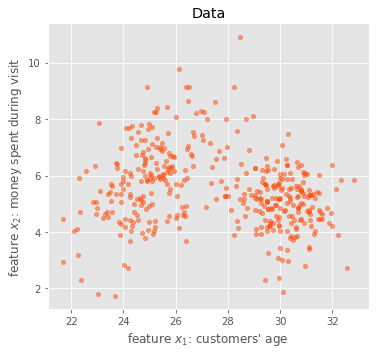

In [2]:
#import the needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

## Choosing nice colors for plot
#if you want to plot for k>3, extend these lists of colors
cmpd = ['orangered','dodgerblue','springgreen']
cmpcent = ['red','darkblue','limegreen']


#read in data from the csv file
df = pd.read_csv("data.csv")
data=df.as_matrix()

#display first 5 rows, to get a feeling for the data
display(df.head(5))


def plotting(data, centroids=None, clusters=None):
    #this function will later on be used for plotting the clusters and centroids. But now we use it to just make a scatter plot of the data
    #Input: the data as an array, cluster means (centroids), cluster assignemnts in {0,1,...,k-1}   
    #Output: a scatter plot of the data in the clusters with cluster means
    plt.figure(figsize=(5.75,5.25))
    plt.style.use('ggplot')
    plt.title("Data")
    plt.xlabel("feature $x_1$: customers' age")
    plt.ylabel("feature $x_2$: money spent during visit")

    alp = 0.5             #data alpha
    dt_sz = 20            #data point size
    cent_sz = 130         #centroid sz
    
    if centroids is None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp ,c=cmpd[0])
    if centroids is not None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp, c=cmpd[0])
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=cent_sz, c=cmpcent)
    if centroids is not None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[cmpd[i] for i in clusters], s=dt_sz, alpha=alp)
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=cmpcent, s=cent_sz)
    if centroids is None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[cmpd[i] for i in clusters], s=dt_sz, alpha=alp)
    
    plt.show()

#plot the data
plotting(data)   

## 3. Exercise
The actual exercise starts from here and it has been divided in 3 tasks:
* 3.1 **Hard clustering with k-means** 
* 3.2 **Handling local minima with k-means**
* 3.3 **Soft clustering with Gaussian mixture models (GMMs)**

Your task is to fill in `### STUDENT TASK ###` in each step.

## 3.1 Hard clustering with k-means
<a id="kmeans"></a>

A popular method for hard clustering is the k-means algorithm which takes as input a list of data points $\mathbf{x}^{(1)},...,\mathbf{x}^{(N)} \in \mathbb{R}^{d}$ and groups them into $k$ non-overlapping clusters $\mathcal{C}_{¡},\ldots,\mathcal{C}_{k}$. Each cluster $\mathcal{C}_{c}$ is characterized by its cluster mean $\mathbf{m}^{(c)} \in \mathbb{R}^{d}$. As a hard-clustering method, k-means assigns each data point $\mathbf{x}^{(i)}$ to exactly one cluster whose index we denote as $y^{(i)} \in 1,...,k$. We can interpret the cluster assignments $y^{(i)}$ as (hidden) labels of the data points. However, we do not have access to the cluster assignment of any data point but rather have to estimate them based on the internal or intrinsic structure of the data set $\mathbf{x}^
{(1)}, \ldots, \mathbf{x}^{(N)}$.


K-means can be summarized as follows:

* Choose initial cluster means $ \mathbf{m}^{(1)},...,\mathbf{m}^{(k)}$

* Repeat until stopping condition is reached:  

    * Assign each datapoint to the cluster whose mean is nearest. 
    
    I.e. for all $i=1,...,N$, do  $$ y^{(i)} = \underset{c'}{\operatorname{argmin}} \|\mathbf{x}^{(i)} - \mathbf{m}^{(c')}\|^2 $$
    
    * Update the new cluster means by calculating the average of the points in the cluster. 
    
    I.e. for all $c=1,...,k$, set 
    \begin{equation*}
    \mathbf{m}^{(c)} = \frac{1}{\mid\{i: y^{(i)}= c\}\mid}{\sum_{i: y^{(i)}= c}\mathbf{x}^{(i)}}     \label{mean}
    \tag{1}
    \end{equation*}
    where $\{i: y^{(i)}= c\}$ represents the set of datapoints belonging to cluster c and $\mid\{i: y^{(i)}= c\}\mid$ the number of datapoints belonging to cluster c.  
    
    Note: Do this only for the clusters with at least one member, those with no members keep the old mean. 


Thus, k-means consists of 4 simple steps:

* __Step 1 - Initialize cluster means.__
* __Step 2 - Update the cluster assignments: assign datapoints to the nearest cluster means.__
* __Step 3 - Update the cluster means by computing the mean (average) of the data points assigned to a particular cluster.__
* __Step 4 - If not finished go to step 2.__

The working of $k$-means is best understood by walking through an example. To this end, we apply $k$-means to the Café customer data. 


### Step 1: Initialize cluster means

We first initialize the cluster means, also called centroids. The most common way is to do this by randomly choosing points between the minimum and maximum values of the data. However, here we select predefined data points, in order to have no randomness. 

In [3]:
def select_centroids(data, k, random_seed=1):   
    #INPUT: N x d data array, k number of clusters. 
    #OUTPUT: k x d array of k randomly assigned mean vectors with d dimensions.
    
    # Random seed will generate exactly same "random" values for each execution.
    # This will ensure similar results between students and avoid confusion.
    np.random.seed(seed=random_seed)
    
    centroids = np.zeros((k, data.shape[1]))
    for i in range(data.shape[1]):
        
        centroids[:,i] = np.random.uniform(np.min(data[:,i]), 
                                           np.max(data[:,i]), 
                                           size = (k))
    return centroids

Run the code below with the number of clusters, k, being 2. You should see a plot of the data points and the initial means as crosses. 

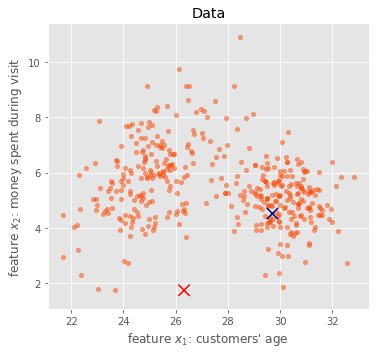

In [4]:
centroids = select_centroids(data, 2)
plotting(data, centroids)

### Step 2: Cluster assignment update: Assign each datapoint to the cluster of nearest cluster mean

In this step your task is to assign each data point $\mathbf{x}^{(i)}$ to the cluster $c$ with the nearest cluster mean $\mathbf{m}^{(c)}$. This distance is measured by the Euclidean distance $\| \mathbf{x}^{(i)} - \mathbf{m}^{(c)} \|$. This will result in a vector of length $N$ whose entries are the cluster assignments $y^{(i)}$ for each point.

#### Tasks
- Implement a Python function `assign_points()` which takes as inputs the data and centroids (cluster means). It should return a vector, named _clusters_, whose entries are the cluster assignments $y^{(i)}$ for each point. 
    - You can use `np.linalg.norm()` to get the Euclidean distance. 
    - You can use `np.argmin()` to get the indices of the minimum values along an axis in an array.
    - Note: Remember that indexing in Python starts from 0, hence it might be easier to number the clusters from 0...k-1, but it is up to you to decide :)  

In [11]:
def assign_points(data, centroids):     
    #INPUT: N x d data array, k x d centroids array.
    #OUTPUT: N x 1 array of cluster assignments in {0,...,k-1}.
    
    clusters = np.zeros(data.shape[0],dtype=np.int32)
    
    #loop through the data first
    for i,x in enumerate(data):
        mind=100000000
        cent=-1
        #check distance with each data point
        for j,c in enumerate(centroids):
            distance=np.linalg.norm(x-c)
            if(distance<mind):
                mind=distance
                cent=j
        clusters[i]=cent
    ### STUDENT TASK ###
    # YOUR CODE HERE
    #raise NotImplementedError()
    return clusters

Let's look at what clusters we have so far.

Run the cell below for that. The datapoints with the same color, belong to the same cluster. 

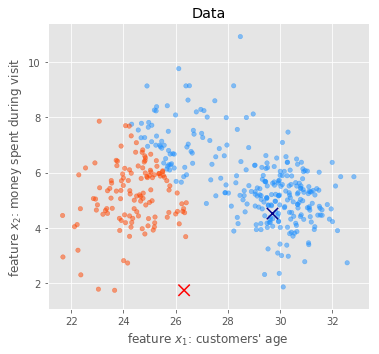

In [12]:
clusters = assign_points(data, centroids)
plotting(data, centroids, clusters)

Does it make sense? Yes? Awesome! Let's proceed further.


### Step 3: update cluster means

We now want to update the cluster means $\mathbf{m}^{(c)}$ of the data points that were assigned to cluster c during the previous step.

#### Tasks
- Implement the Python function `move_centroids()` which takes as input the data, old centroids and cluster assignments. It should return the new centroids. 
    - You can use `np.mean()` to compute the mean (see Eq. (1)) of all points belonging to one cluster. 
    - You need to keep in mind that there might be a situation when none of the points were assigned to a cluster. If this is the case, you should assign the old centroid as new centroid.

In [19]:
def move_centroids(data, old_centroids, clusters):
    #INPUT:  N x d data array, k x d centroids array, N x 1 array of cluster assignments
    #OUTPUT: k x d array of relocated centroids
    
    new_centroids = np.zeros(old_centroids.shape)
    ### STUDENT TASK ###
    # YOUR CODE HERE
    for c in range(len(old_centroids)):
        loc = clusters == c
        #print(loc)
        if sum(loc)>0:
            new_centroids[c]= np.mean(data[loc],axis=0)
        else:
            new_centroids[c] = old_centroids[c]
    return new_centroids

Let's see if the cluster means moved. Run the cell below for that.

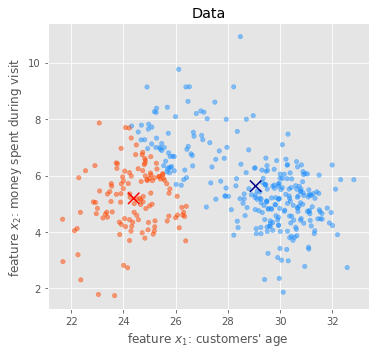

In [20]:
new_centroids = move_centroids(data, centroids,clusters)
plotting(data, new_centroids, clusters)

Are the cluster means in the middle of the clusters now? Yes? Nice! We're ready to assemble the whole algorithm now!

### Step 4 - Repeat steps 2 and 3 until convergence

Now it is time to combine the functions you have created so far into the final algorithm. The new part here is the loop where you repeat steps 2 and 3 until the stopping criterion is fulfilled. Here we are using as stopping criterion a fixed number of iterations. But there are many ways to define a stopping criterion, for example, by checking if the clusters are changing.  

Tasks
- In the Python function `k_means()` call the functions that were created in step 1 to 3 in order to get the full k-means algorithm. It should output the final centroids and clusters after the given number of iterations, `num_iters`

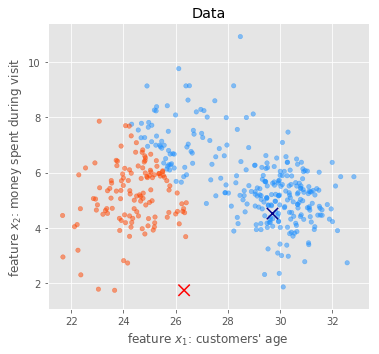

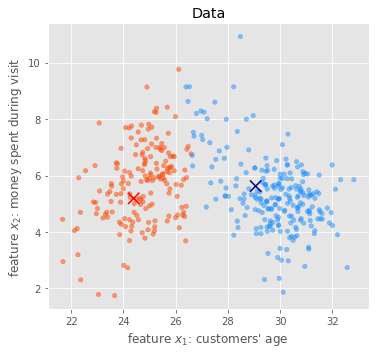

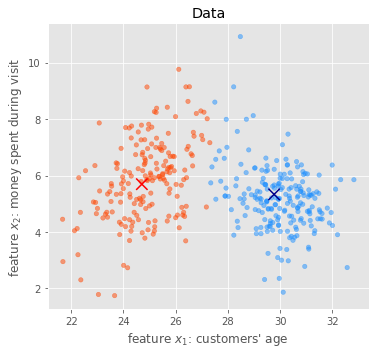

The final cluster mean values are: [[ 24.94326652   5.87406858]
 [ 30.03164456   5.13271688]]


In [21]:
def k_means(data, k, random_seed=1, num_iters=10,plot=True):
    #INPUT: N x d data array, k number of clusters, number of iterations, boolean plot.
    #OUTPUT: N x 1 array of cluster assignments.
    
    ### STUDENT TASK ###
    #step 1
    #centroids = ...
    # YOUR CODE HERE
    centroids=select_centroids(data,k)
    #raise NotImplementedError()
    
        #loop for steps 2 and 3
    for i in range(num_iters):
        ### STUDENT TASK ###
        #step 2
        #clusters = ...
        # YOUR CODE HERE
        #raise NotImplementedError()
        clusters=assign_points(data,centroids)
        #plotting
        if plot==True and i<3:
            plotting(data,centroids,clusters)
        
        ### STUDENT TASK ###
        #step 3
        centroids = move_centroids(data,centroids,clusters)
        # YOUR CODE HERE
        #raise NotImplementedError()
 
    return centroids,clusters


centroids,clusters = k_means(data, 2)
print("The final cluster mean values are:",centroids)

## 3.2. Handling local minima in k-means
<a id="local"></a>

As introduced in the course book, the k-means algorithm aims at minimizing the __empirical risk__: 

$$\mathcal{E}  ( \{\mathbf{m}^{(c)}\}_{c=1}^{k},\{y^{(i)}\}_{i=1}^{N} \mid \{\mathbf{x}^{(i)}\}_{i=1}^{N} )
=\frac{1}{N} \sum_{i=1}^{N} {\left\|\mathbf{x}^{(i)}-\mathbf{m}^{(y^{(i)})}\right\|^2}
$$

Since the empirical risk is a highly non-convex function of the cluster means and assignments, the k-means method will sometimes get trapped in a local minimum.

It is therefore useful to run k-means several times with different initializations for the cluster means and choose the cluster assignment that yields the smallest empirical risk. 

Tasks
- Implement a Python function `empirical_risk()` which takes as input the data, clusters and centroids and returns the empirical risk. 
- Then run the cell below, which exectues k-means 50 times, each time with a different initialization for cluster means, and plots the best and worst cluster division for k=3.

In [22]:
from ipywidgets import IntProgress
from IPython.display import display

def empirical_risk(data, clusters, centroids):  
    #INPUT: N x d data array, k x d array of k mean vectors (centroids), 
    #       N x 1 array of cluster assignments.
    #OUTPUT: value of empirical risk
    
    ### STUDENT TASK ###
    # YOUR CODE HERE
    risk=0
    for i,x in enumerate(data):
        risk+=np.linalg.norm(x-centroids[clusters[i]])**2 
    risk = risk/data.shape[0]
    return risk

def new_k_means(data, k,plot=True):  
    # This will display a progress bar during k-mean execution
    f = IntProgress(description=f'KM (k={k}):',min=0, max=50)
    display(f)
    
    
    # initializing the array where we collect all cluster assignments  
    cluster_collection = np.zeros((50, data.shape[0]),dtype=np.int32)
    # initializing the array where we collect all risk values 
    risk_collection = np.zeros(50)
    
    for i in range(50):
        f.value +=1
        centroids,clusters=k_means(data,k,random_seed=i,plot=False)
        risk_collection[i] = empirical_risk(data, clusters, centroids)
        cluster_collection[i,:] = clusters
        
    #find the best cluster assignment and print the lowest found empirical risk
    min_ind = np.argmin(risk_collection)
    max_ind=np.argmax(risk_collection)
    if plot==True:
        print("Cluster division with lowest empirical risk")
        plotting(data,clusters=cluster_collection[min_ind,:])
        print("Cluster division with highest empirical risk")
        plotting(data,clusters=cluster_collection[max_ind,:])
    
        print('min empirical risk is ', np.min(risk_collection))
    
    #Let's remove progress bar
    f.close()
    return cluster_collection[min_ind,:],risk_collection

IntProgress(value=0, description='KM (k=3):', max=50)

Cluster division with lowest empirical risk


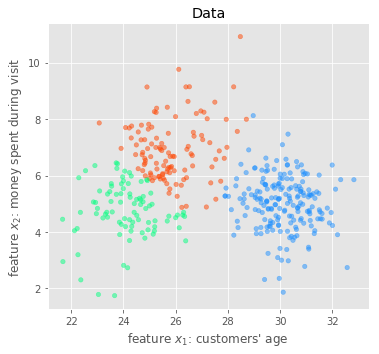

Cluster division with highest empirical risk


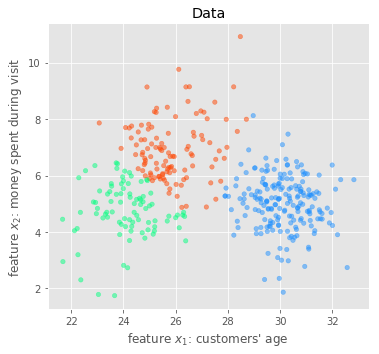

min empirical risk is  2.02178864809


In [23]:
best_cluster,risk=new_k_means(data,3)

### Choosing the best number of clusters
We often don't know what the best number of clusters is. One way to find this out is by running the k-means algorithm for several numbers of clusters and choosing the number of clusters which has the best balance between a low empirical risk and a low complexity (i.e. small number of clusters). 
Run the code below to get a plot of the number of clusters vs the empirical risk. What do you think would be the optimal number of clusters for this dataset?
Note: this will take some time to finish running

IntProgress(value=0, description='KM (k=1):', max=50)

IntProgress(value=0, description='KM (k=2):', max=50)

IntProgress(value=0, description='KM (k=3):', max=50)

IntProgress(value=0, description='KM (k=4):', max=50)

IntProgress(value=0, description='KM (k=5):', max=50)

IntProgress(value=0, description='KM (k=6):', max=50)

IntProgress(value=0, description='KM (k=7):', max=50)

IntProgress(value=0, description='KM (k=8):', max=50)

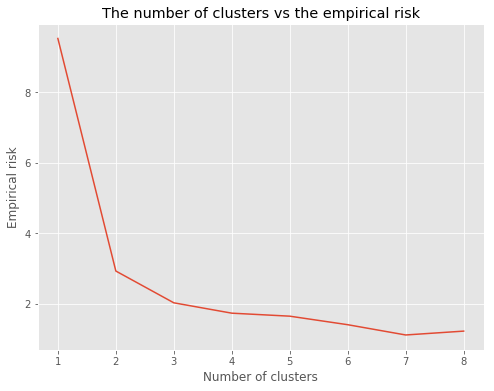

In [24]:
risks=np.zeros(8)
for i in range(0,8):
    best_cluster,risk=new_k_means(data,i+1,plot=False)
    risks[i]=np.mean(risk)

fig=plt.figure(figsize=(8,6))
plt.plot(range(1,9),risks)
plt.xlabel('Number of clusters')
plt.ylabel('Empirical risk')
plt.title("The number of clusters vs the empirical risk")
plt.show()

## 3.3 Soft clustering with Gaussian Mixture Models (GMM) 
<a id="GMM"></a>

The information provided by $k$ means is rather coarse-grained: even if two data points belong to the same cluster, their location within the cluster might be very different. Let us now consider soft-clustering methods which provide a more fine-grained information about the cluster structure of a data set. 

Considering again the customer segmentation for a Cafe business, we might like to have some measure for the extend (or degree) by which a customer belongs to various groups. This is a soft-clustering problem where we associate each data point $\mathbf{x}^{(i)}$(which represents a particular customer) with a membership-vector $\mathbf{y}^{(i)}= (y^{(i)}_1,...,y^{(i)}_k) \in [0,1]^k$ whose entry $y^{(i)}_c$ is the degree by which we assign $\mathbf{x}^{(i)}$ to cluster $\mathcal{C}_c$. 

A principled approach to obtaining a soft-clustering method is based on interpreting the data points $\mathbf{x}^{(i)}$ as realizations of a random vector $\mathbf{x}$ with some underlying probability distribution $p(\mathbf{x})$. In particular, we can represent a cluster $\mathcal{C}_{c}$ by a Gaussian distribution with mean vector $\mathbf{m}^{(c)}$ and covariance matrix $\mathbf{C}^{(c)}$. The probability density function of such a Gaussian distribution is denoted 

\begin{equation}
\mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)}) = \frac{1}{\sqrt{{\rm det} \big(2 \pi \mathbf{C}^{(c)}\big)}} {\rm exp } \bigg( - \big(\mathbf{x}^{(i)} - \mathbf{m}^{(c)} \big)^{T} \big(\mathbf{C}^{(c)}\big)^{-1}  \big(\mathbf{x}^{(i)} - \mathbf{m}^{(c)} \big)\bigg).
\end{equation}

The overall probability distribution is then obtained as a **Gaussian mixture** 

\begin{equation}
p(\mathbf{x}) = p_{1} \mathcal{N}(\mathbf{x} ; \mathbf{m}^{(1)}, \mathbf{C}^{(1)}) + p_{2} \mathcal{N}(\mathbf{x} ; \mathbf{m}^{(2)}, \mathbf{C}^{(2)})
\end{equation}

with coefficients $p_{1},p_{2} \geq 0$ satisfying $p_{1} + p_{2} =1$. The coefficient $p_{1}$ is the probability that a data point is drawn from cluster $\mathcal{C}_{1}$ and, similarly, $p_{2}$ is the probability that a data point is drawn from cluster $\mathcal{C}_{2}$. Note that the distribution $p(\mathbf{x})$ depends (is parametrized by) the coefficients $p_{1},p_{2}$, the cluster means $\mathbf{m}^{(1)},\mathbf{m}^{(2)}$ 
and the covariance matrices $\mathbf{C}^{(1)},\mathbf{C}^{(2)}$. This is when we set the number of clusters to 2, but just as in k-means we can also set it to another number. 

Under the probabilistic model $p(\mathbf{x})$, the degree $y_{c}^{(i)}$ of a data point $\mathbf{x}^{(i)}$ belonging to cluster $\mathcal{C}_{c}$ can be defined as the probability that $\mathbf{x}^{(i)}$ is generated (drawn) from the Gaussian distribution associated with $\mathcal{C}_{c}$:  

$$\mathbf{y}^{(i)}_c = \frac{p_{c} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)})}{\sum_{c'=1}^k p_{c'} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c')}, \mathbf{C}^{(c')})} $$

After determining the degrees of belonging, we can then update or guess (estimate) the cluster probabilities $p_{1},p_{2}$, cluster means $\mathbf{m}^{(1)}, \mathbf{m}^{(2)}$ and covariance matrices $\mathbf{C}^{(1)},\mathbf{C}^{(2)}$.

In summary this algorithm consists of 4 steps (just as k-means):

* __Step 1 - Initialize the cluster parameters. This are the means and covariances for every cluster.__
* __Step 2 - Update the degree of data point \mathbf{x}^{(i)} belonging to cluster c.__
* __Step 3 - Update the cluster parameters, i.e. the means and covariances.__
* __Step 4 - Put steps 2 and 3 in a loop__

So lets go through these steps one by one and compose the algorithm. 

### Step 1: Initialize the cluster parameters

We first choose an initial mean, covariance matrix and coefficient for each cluster. The means are initialized randomly,as initialization for the covariance matrix we take the identity matrix and all coefficients are set to 0.5. 

In [25]:
def initialize_parameters(data, k,random_seed=1):
    
    # Random seed will generate exactly same "random" values for each execution.
    # This will ensure similar results between students and avoid confusion.
    np.random.seed(seed=random_seed)
    
    means = np.zeros((k, data.shape[1]))
    for i in range(data.shape[1]):
        means[:,i] = np.random.uniform(np.min(data[:,i]), 
                                           np.max(data[:,i]), 
                                           size = (k)) 
    covariances=np.zeros((k,data.shape[1],data.shape[1]))
    
    for f in range(k):
        covariances[f]=np.identity(data.shape[1])
    coefficients=np.ones(k)*0.5
    return means, covariances,coefficients

In [26]:
def plot_GMM(data,means,covariances,k,cluster_vectors=None):
    if cluster_vectors is None:
        plt.scatter(data[:,0], data[:,1], s=13,alpha=0.5)
    else:
        clusters = np.argmax(cluster_vectors,axis=0)
        plt.scatter(data[:,0], data[:,1], c=[cmpd[i] for i in clusters], s=13,alpha=0.5)

    #Visualization of results
    x_plot = np.linspace(19,35, 100)
    y_plot = np.linspace(0,12, 100)

    for i in range(k):
        x_mesh, y_mesh = np.meshgrid(x_plot, y_plot)
        z= plt.mlab.bivariate_normal(x_mesh, y_mesh, np.sqrt(covariances[i,0, 0]), \
                                    np.sqrt(covariances[i,1, 1]), means[i,0], means[i,1],covariances[i,0,1])
        plt.contour(x_mesh , y_mesh , z,4,colors=cmpcent[i],alpha=0.5)
        plt.scatter( [means[i,0]], [means[i,1]], marker='x',c=cmpcent[i])

    plt.title("Soft clustering with GMM")
    plt.xlabel("feature x_1: customers' age")
    plt.ylabel("feature x_2: money spent during visit")
    plt.show()

Let's calculate and plot the initializations. The circles indicate the probability distribution, based on the covariances. 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  from ipykernel import kernelapp as app


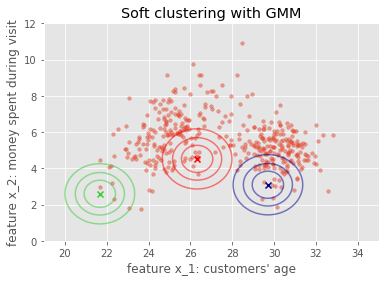

In [27]:
means,covariances,coefficients=initialize_parameters(data,3)
plot_GMM(data,means,covariances,3)

### Step 2: Assign a probability for each datapoint belonging to each cluster

We now want to calculate for each datapoint the probability it belongs to each cluster. The probability of belonging to a cluster, is also called the degree of belonging. We can calculate this by the following formula:

$$y^{(i)}_c = \frac{p_{c} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)})}{\sum_{c'=1}^k p_{c'} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c')} , \mathbf{C}^{(c')})} $$

Here, $\mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)})$ is the probability density function (or pdf for short). 

In [28]:
from scipy.stats import multivariate_normal # Multivariate normal random variable


def update_degrees_of_belonging(data, means, covariances,coefficients,k): 
    cluster_vectors=np.zeros((k,data.shape[0]))   
    for i in range(data.shape[0]):
        belonging_all=np.sum([coefficients[f]*multivariate_normal.pdf(data[i],means[f],covariances[f]) for f in range(k)])
        for t in range(k):
            cluster_vectors[t,i]=coefficients[t]*multivariate_normal.pdf(data[i],means[t],covariances[t])/belonging_all
    
    return cluster_vectors

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  from ipykernel import kernelapp as app


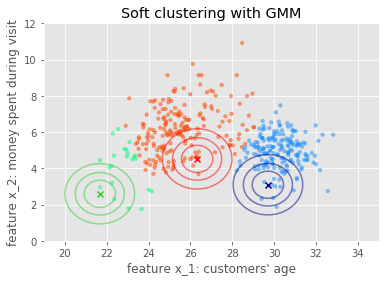

In [29]:
cluster_vectors=update_degrees_of_belonging(data,means,covariances,coefficients,3)
plot_GMM(data,means,covariances,3,cluster_vectors)

### Step 3: Set the new cluster parameters

Now we want to update the cluster parameters. In contrast to $k$-means, where we only updated the clusters means here we also have to update the covariances and coefficients. Since we use degrees of belonging the formula for updating the means is also slightly different compared to k-means. See the updating formulas below. 

$$p_{c}=\frac{N_{c}}{N}$$
$$\mathbf{m}^{(c)} = \frac{1}{N_c} \sum_{i=1}^N y_c^{(i)}\mathbf{x}^{(i)} $$
$$\mathbf{C}^{(c)} = \frac{1}{N_c} \sum_{i=1}^N y_c^{(i)}(\mathbf{x}^{(i)} - \mathbf{m}^{(c)})(\mathbf{x}^{(i)} - \mathbf{m}^{(c)})^T $$
where $N_c = \sum_{i=1}^N y_c^{(i)}$

In [30]:
def update_GMM_pars(data, cluster_vectors,k): 
    means_new = np.zeros((k, data.shape[1]))
    covariances_new=np.zeros((k,data.shape[1],data.shape[1]))
    coefficients_new=np.zeros(k)
    
    for i in range(k):
        sum_k=np.sum(cluster_vectors[i])
        coefficients_new[i]=sum_k/len(data)
        means_new[i]=data.T@cluster_vectors[i]/sum_k
        for l in range(data.shape[0]):
            covariances_new[i]+=np.outer( data[l] - means_new[i], data[l] - means_new[i]) * cluster_vectors[i,l]
        covariances_new[i]=covariances_new[i]/sum_k
    return means_new,covariances_new,coefficients_new

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  from ipykernel import kernelapp as app


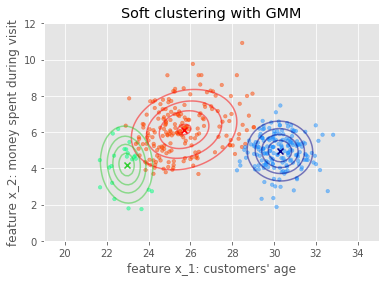

In [31]:
means,covariances,coefficients=update_GMM_pars(data, cluster_vectors,3)
plot_GMM(data,means,covariances,3,cluster_vectors)

### Step 4: Put steps 2 and 3 in a loop

The last step is to put all the pieces together by initializing the parameters and then putting step 2 and 3 inside a loop. This is very similar to the process in k-means. 

In [32]:
def GMM_clustering(data,k,num_iters,random_seed=0):
    # Step 1: 
    means,covariances,coefficients = initialize_parameters(data,k,random_seed)
    
    # This will display a progress bar during GMM execution
    f = IntProgress(description=f'GMM (k={k}):',min=0, max=num_iters)
    display(f)
    for i in range(num_iters):
        # Step 2:
        cluster_vectors = update_degrees_of_belonging(data, means, covariances,coefficients,k)
        # Step 3:
        means,covariances,coefficients=update_GMM_pars(data, cluster_vectors,k)
        
        # Iterate progress bar
        f.value +=1
    
    return means, covariances, cluster_vectors

Now run the code to calculate the final means and covariance matrices and plot the result!
In the plot we can clearly see an overlap of the clusters, i.e. some points belonging to in this case 2 clusters. What does this mean and how would this influence the customer segmentation and marketing strategy for the cafe?

IntProgress(value=0, description='GMM (k=3):', max=50)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  from ipykernel import kernelapp as app


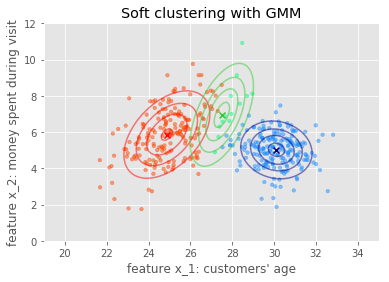

The means are [[ 24.87515077   5.8639891 ]
 [ 30.109949     5.01680331]
 [ 27.5002508    6.95363818]]
The covariance matrices are [[[ 1.48998332  0.81579883]
  [ 0.81579883  2.05972989]]

 [[ 0.98782389 -0.10801821]
  [-0.10801821  0.8659114 ]]

 [[ 0.77271062  0.80393491]
  [ 0.80393491  2.73324751]]]


In [33]:
means,covariances,cluster_vectors=GMM_clustering(data,3,50)
plot_GMM(data,means,covariances,3,cluster_vectors)
print("The means are",means)
print("The covariance matrices are",covariances)